In [47]:
import pandas as pd
import datetime
from geopy import distance
import numpy as np
from collections import defaultdict
import progressbar
import operator
import secrets
import random
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
df = pd.read_pickle('prepared_telco_data.pickle')


In [48]:
df_200 = pd.read_pickle('200accesspointdata.pickle')

In [49]:
class Species():
    frontier = 0
    distance = 0 
    servers = []
    solution = []
    accessDelay = 0
    workloadBalance = 0
    id = 0 
    fitness = 0
    def __init__(self,f,d,s,sol,wB,aD, id):
        self.frontier = f
        self.distance = d 
        self.servers = s
        self.solution = sol
        self.accessDelay = aD
        self.workloadBalance = wB
        self.id = id
    def __repr__(self):
        return "Species: " + str(self.id) + " Frontier: " + str(self.frontier) + " distance: " + str(self.distance) + " Access Delay: " + str(self.accessDelay) + " Workload Balance: " + str(self.workloadBalance) + " Servers: " + str(len(self.servers))

In [50]:
def accessDelay(solution, data):
    delay = 0
    i = 0
    for location in solution:
        delay += distance.distance(data.iloc[location]['location'],data.iloc[i]['location']).km
        i+=1
    return delay
def workloadBalance(solution, data):
    servers = dict.fromkeys(solution,0)
    for index,row in data.iterrows():
        servers[solution[index]] +=  row['workload']
    total = 0
    mean = sum(servers.values())/len(servers)
    for key,value in servers.items():
        total += (value - mean)**2
    return np.sqrt(total/len(servers))
def checkDominance(a,b, check_servers = False):
    if check_servers:
        if a.accessDelay < b.accessDelay and a.workloadBalance <= b.workloadBalance and len(a.servers) <= len(b.servers):
            return True
        if a.accessDelay <= b.accessDelay and a.workloadBalance < b.workloadBalance and len(a.servers) <= len(b.servers):
            return True
        if a.accessDelay <= b.accessDelay and a.workloadBalance <= b.workloadBalance and len(a.servers) < len(b.servers):
            return True
    else:
        if a.accessDelay < b.accessDelay and a.workloadBalance <= b.workloadBalance:
            return True
        if a.accessDelay <= b.accessDelay and a.workloadBalance < b.workloadBalance:
            return True
    return False

In [59]:
def naive_solution(data,servers):
    solution = []
    for j in range(0,len(data)):
        best_server = 0
        min_dist = np.inf
        for server in servers:
            dist = distance.distance(data.iloc[j]['location'],data.iloc[server]['location']).km
            if dist < min_dist:
                best_server = server
                min_dist = dist
        solution.append(best_server)
    return solution
def init_pop(data, server_count = 20, pop_size = 100, server_variance = 5):
    pop = {}
    for i in progressbar.progressbar(range(pop_size)):
        if server_variance:
            server_n = np.random.randint(server_count-server_variance, server_count + server_variance)
        else:
            server_n = server_count
        servers = list(np.random.choice(range(len(data)),server_n,False))
        solution = naive_solution(data,servers)
        pop[i] = Species(0,0,servers,solution, workloadBalance(solution,data), accessDelay(solution,data),"Gen 0, Species:" + str(i))
    return pop



In [52]:
def nonDominatedSort(population, check_servers = False):
    S = {}
    n = {}
    F = defaultdict(list)
    for key in population.keys():
        S[key] = []
        n[key] = 0
        for key2 in population.keys():
            if key == key2:
                pass
            elif checkDominance(population[key],population[key2], check_servers):
                S[key].append(key2)
            elif checkDominance(population[key2],population[key], check_servers):
                n[key] += 1
        if n[key] == 0:
            population[key].frontier = 0  #set rank of species internally 
            F[0].append(key)
    i = 0
    while F[i] != []:
        Q = []
        for p in F[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    population[q].frontier = i + 1 #set rank of species internally 
                    Q.append(q)
        i = i + 1
        if not Q:
            break
        F[i] = Q
    return F

In [53]:
def crowdingDistance(population, check_servers = False):
    #set distances to 0 
    for member in population:
        member.distance = 0

    #sort by access delay and compute distances
    population = sorted(population, key = lambda x: x.accessDelay)
    population[0].distance = -np.inf
    population[-1].distance = -np.inf
    for i in range(1,len(population)-1):
        population[i].distance = population[i].distance - (population[i+1].accessDelay - population[i-1].accessDelay)/(population[-1].accessDelay - population[0].accessDelay)
    
    #sort by workload balance and compute distances
    population = sorted(population, key = lambda x: x.workloadBalance)
    population[0].distance = -np.inf
    population[-1].distance = -np.inf
    for i in range(1,len(population)-1):
        population[i].distance = population[i].distance - (population[i+1].workloadBalance - population[i-1].workloadBalance)/(population[-1].workloadBalance - population[0].workloadBalance)
    
    if check_servers:
        #sort by num servers and compute distances
        population = sorted(population, key = lambda x: len(x.servers))
        population[0].distance = -np.inf
        population[-1].distance = -np.inf
        for i in range(1,len(population)-1):
            population[i].distance = population[i].distance - (len(population[i+1].servers) - len(population[i-1].servers))/(len(population[-1].servers) - len(population[0].servers))


In [54]:
def roulette(choices):
    choice_odds = [] 
    #get odds for each choice
    for i in range(len(choices)):
        choice_odds.append((2*(len(choices) - i))/(len(choices)*(len(choices)+1)))

    #pick a choice
    max = sum([x for x in choice_odds])
    pick = np.random.uniform(0, max)
    current = 0
    selected_choice = 0
    for x in choice_odds:
        current += x
        if current >= pick:
            break
        selected_choice += 1
    return selected_choice
def selection(population, frontiers):
    #pick a frontier
    selected_frontier = roulette(frontiers)
    #get distances for each member of frontier
    distances = []
    for i in frontiers[selected_frontier]:
        distances.append((population[i].distance,i))
    distances = sorted(distances)

    #pick a specific member
    selection = roulette(distances)
    try:
        selected_member = distances[selection]
    except Exception:
        print(selection)
        print(distances)
    selected_member = selected_member[1]
    return population[selected_member]


In [55]:

def mutate(data, species, fixed_servers):
    #to start available mutations will be one server is randomly changed
    if fixed_servers:
        server = np.random.choice(species.servers)
        new_server = np.random.randint(0,len(species.solution))
        species.servers = list(species.servers)
        species.servers.append(new_server)
        species.servers.remove(server)
        species.solution = naive_solution(data,species.servers)
        species.accessDelay = accessDelay(species.solution,data)
        species.workloadBalance = workloadBalance(species.solution, data) 

def breed(data,a,b,gen,id,fixed_servers):
    if fixed_servers:
        server_count = len(a.servers)
        new_servers = set(a.servers) | set(b.servers)
        try:
            new_servers = np.random.choice(list(new_servers), server_count, False)
        except Exception:
            print(a.servers)
            print(b.servers)
            print(new_servers)
        new_solution = []
        set_new_servers = set(new_servers)
        for i in range(len(a.solution)):
            if a.solution[i] in set_new_servers:
                new_solution.append(a.solution[i])
            elif b.solution[i] in set_new_servers:
                new_solution.append(b.solution[i])
            else:
                best_server = 0
                min_dist = np.inf
                for server in new_servers:
                    dist = distance.distance(data.iloc[i]['location'],data.iloc[server]['location']).km
                    if dist < min_dist:
                        best_server = server
                        min_dist = dist
                new_solution.append(best_server)
        return Species(0,0,new_servers,new_solution, workloadBalance(new_solution,data), accessDelay(new_solution,data), "Gen " + str(gen) + ", Species:" + str(id))

def new_generation(data,population,gen, mutation_rate, fixed_servers):       
    pop_list = sorted(population.values(), key = operator.attrgetter("frontier", "distance"))
    next_gen = {}
    i = 1
    frontiers = nonDominatedSort(population)
    for i in tqdm_notebook(range(len(population)),leave=False, desc='Next Generation'): 
        a = selection(population,frontiers)
        b = selection(population,frontiers)
        new_species = breed(data,a,b,gen,i,fixed_servers)
        n = np.random.random(1)[0]
        if n < mutation_rate:
            mutate(data, new_species, fixed_servers)
        next_gen[new_species.id] = new_species
    return next_gen

In [60]:
access_delay_averages = []
workload_balance_averages = []
access_delay_mins = []
workload_balance_mins = []
def evolution(data,generations = 20, pop_size = 150, server_count = 20, fixed_servers = True):
    population = init_pop(df_200,pop_size=pop_size, server_count =server_count,server_variance = 0)
    for i in tqdm_notebook(range(generations), desc='Generation'):
        gen = {}
        frontiers = nonDominatedSort(population)
        crowdingDistance(list(population.values()))
        pop_list = sorted(population.values(), key = operator.attrgetter("frontier", "distance"))
        population = {}
        for k in range(0,pop_size):
            id = pop_list[k].id
            population[id] = pop_list[k]

        if i%1 == 0:
            print("Generation: " + str(i))
            ads = []
            wbs = []
            for key,value in population.items():
                ads.append(value.accessDelay)
                wbs.append(value.workloadBalance)
            plt.xlabel("Access Delay")
            plt.ylabel("Workload Balance")
            plt.scatter(ads,wbs)
            plt.show()
            average_ad = sum(ads)/len(ads)
            average_wb = sum(wbs)/len(wbs)
            access_delay_averages.append(average_ad)
            workload_balance_averages.append(average_wb)
            access_delay_mins.append(min(ads))
            workload_balance_mins.append(min(wbs))
            print("Average Access Delay:" + str(average_ad))
            print("Average Workload Balance:" + str(average_wb))
            print("Minimum Access Delay:" + str(min(ads)))
            print("Minimum Workload Balance:" + str(min(wbs)))

        
        next_gen = new_generation(data,population, i+1, .1, fixed_servers)
        population.update(next_gen)
    gen = {}
    frontiers = nonDominatedSort(population)
    j = 0
    while len(gen) < pop_size:
        front = [population[x] for x in frontiers[j]]
        crowdingDistance(front)
        gen.update({key: value for key, value in population.items() if key in frontiers[j]})
        j += 1
    population = gen
    return frontiers,population
   
        

100% (150 of 150) |######################| Elapsed Time: 0:05:21 Time:  0:05:21


Generation: 0


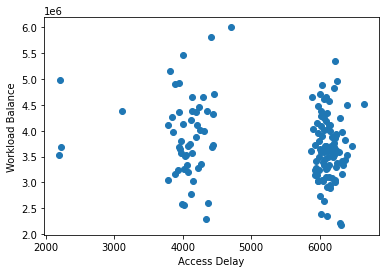

Average Access Delay:5376.962229931322
Average Workload Balance:3755709.5192403793
Minimum Access Delay:2201.6995895142304
Minimum Workload Balance:2180940.8054839773


Generation: 1


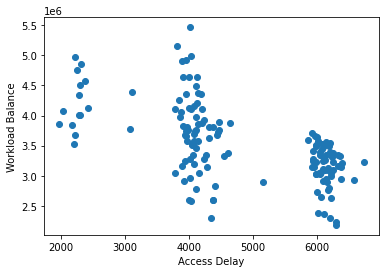

Average Access Delay:4785.137533476103
Average Workload Balance:3530698.2402532315
Minimum Access Delay:1973.8424951481006
Minimum Workload Balance:2180940.8054839773


Generation: 2


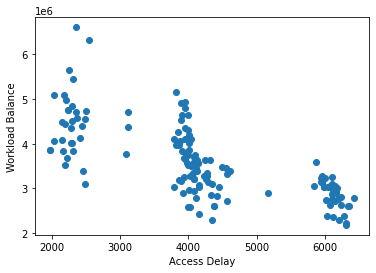

Average Access Delay:4215.947079234244
Average Workload Balance:3581157.1635111975
Minimum Access Delay:1973.8424951481006
Minimum Workload Balance:2180940.8054839773


Generation: 3


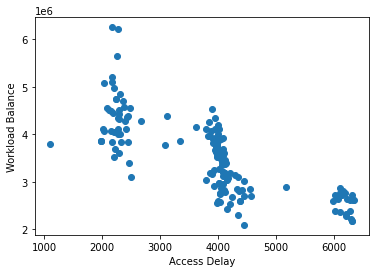

Average Access Delay:3805.542510646592
Average Workload Balance:3540672.9866140853
Minimum Access Delay:1097.2800970073865
Minimum Workload Balance:2090701.2528573994


Generation: 4


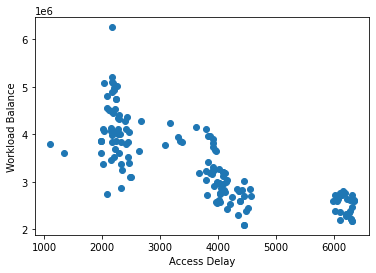

Average Access Delay:3673.209694992123
Average Workload Balance:3388179.622269361
Minimum Access Delay:1097.2800970073865
Minimum Workload Balance:2090701.2528573994


Generation: 5


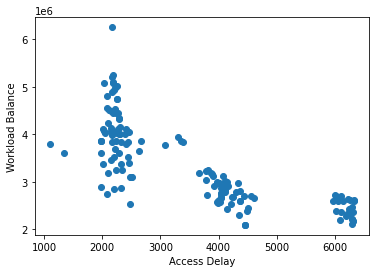

Average Access Delay:3557.653626728905
Average Workload Balance:3335247.785595218
Minimum Access Delay:1097.2800970073865
Minimum Workload Balance:2090701.2528573994


Generation: 6


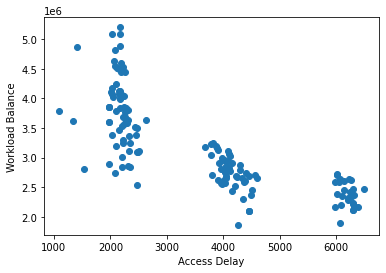

Average Access Delay:3635.9128694194665
Average Workload Balance:3149176.35624844
Minimum Access Delay:1097.2800970073865
Minimum Workload Balance:1863789.8536195871


Generation: 7


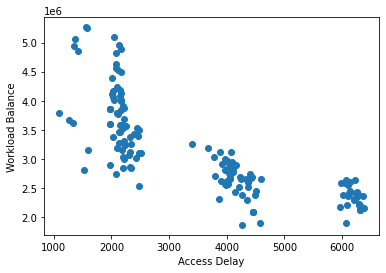

Average Access Delay:3520.785604763786
Average Workload Balance:3126620.1762319985
Minimum Access Delay:1097.2800970073865
Minimum Workload Balance:1863789.8536195871


Generation: 8


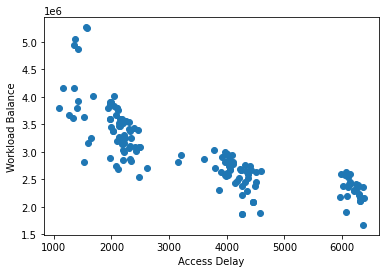

Average Access Delay:3498.7814938066917
Average Workload Balance:2979456.3455963475
Minimum Access Delay:1097.2800970073865
Minimum Workload Balance:1670675.8653898502


Generation: 9


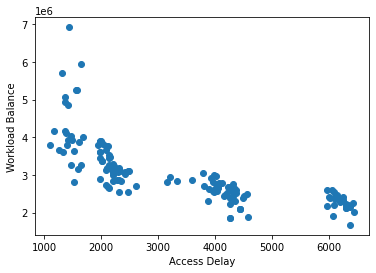

Average Access Delay:3395.1521468834085
Average Workload Balance:3021767.5438666507
Minimum Access Delay:1097.2800970073865
Minimum Workload Balance:1670675.8653898502


[35, 145, 7, 3, 163, 14, 148, 104, 142, 114, 172, 155, 193, 181, 187, 49, 118, 162, 125, 49]
[35, 145, 7, 3, 163, 14, 148, 104, 142, 114, 172, 155, 193, 181, 187, 49, 118, 162, 125, 49]
{3, 7, 14, 142, 145, 148, 155, 162, 35, 163, 172, 49, 181, 187, 193, 104, 114, 118, 125}
Generation: 10


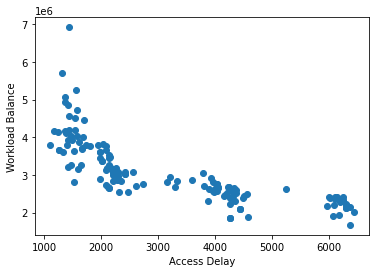

Average Access Delay:3198.292630803252
Average Workload Balance:3049420.8808786767
Minimum Access Delay:1097.2800970073865
Minimum Workload Balance:1670675.8653898502


Generation: 11


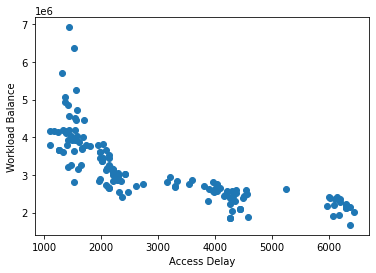

Average Access Delay:3051.1540400295944
Average Workload Balance:3101434.779384582
Minimum Access Delay:1097.2800970073865
Minimum Workload Balance:1670675.8653898502


Generation: 12


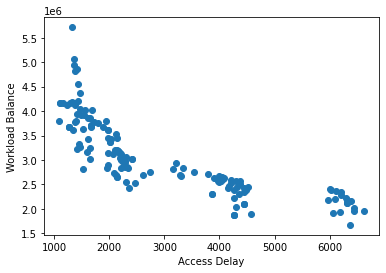

Average Access Delay:3006.8673968527714
Average Workload Balance:3032114.393412919
Minimum Access Delay:1097.2800970073865
Minimum Workload Balance:1670675.8653898502


Generation: 13


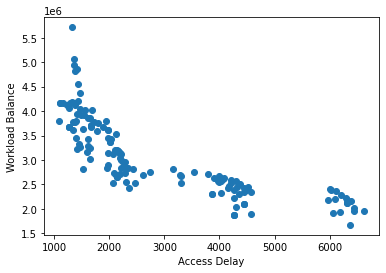

Average Access Delay:2933.022752691014
Average Workload Balance:3044335.63296276
Minimum Access Delay:1097.2800970073865
Minimum Workload Balance:1670675.8653898502


Generation: 14


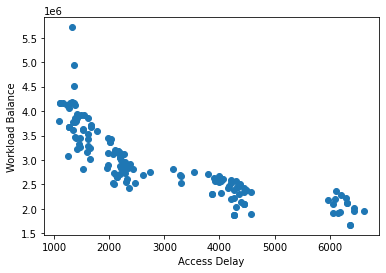

Average Access Delay:2968.7155606388806
Average Workload Balance:2930797.4522161908
Minimum Access Delay:1097.2800970073865
Minimum Workload Balance:1670675.8653898502


Generation: 15


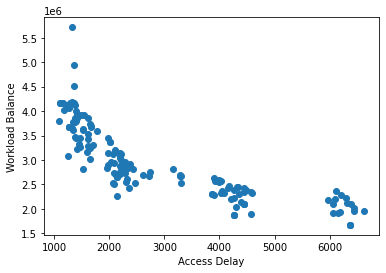

Average Access Delay:2899.7336871857724
Average Workload Balance:2933552.823452301
Minimum Access Delay:1097.2800970073865
Minimum Workload Balance:1670675.8653898502


Generation: 16


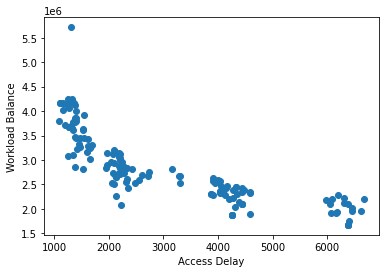

Average Access Delay:3009.7028961257593
Average Workload Balance:2847142.220116791
Minimum Access Delay:1097.2800970073865
Minimum Workload Balance:1670675.8653898502


Generation: 17


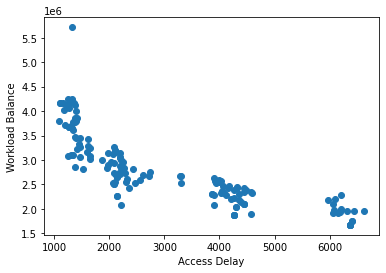

Average Access Delay:3037.967923851176
Average Workload Balance:2795819.4343704204
Minimum Access Delay:1097.2800970073865
Minimum Workload Balance:1670675.8653898502


Generation: 18


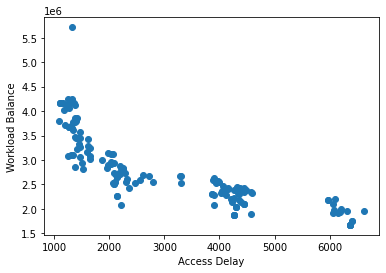

Average Access Delay:3032.1990873109407
Average Workload Balance:2780844.5627749213
Minimum Access Delay:1097.2800970073865
Minimum Workload Balance:1670675.8653898502


Generation: 19


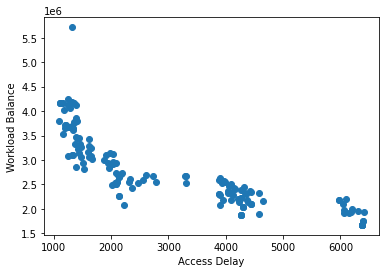

Average Access Delay:3046.7189535303414
Average Workload Balance:2762029.898210683
Minimum Access Delay:1097.2800970073865
Minimum Workload Balance:1670675.8653898502


In [61]:
frontiers,population = evolution(df_200,pop_size=150)

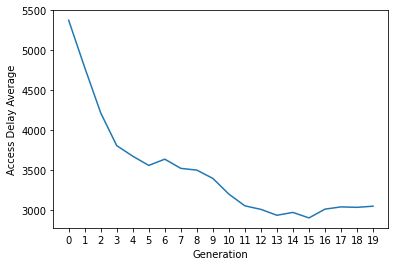

In [81]:
plt.ylabel("Access Delay Average")
plt.xlabel("Generation")
plt.xticks(range(0,20))
plt.plot(access_delay_averages)

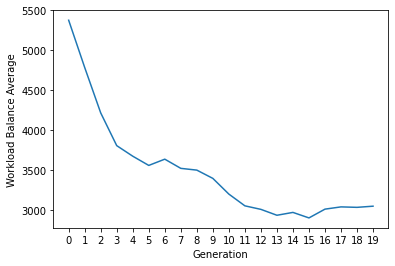

In [82]:
plt.ylabel("Workload Balance Average")
plt.xlabel("Generation")
plt.xticks(range(0,20))
plt.plot(access_delay_averages)

In [64]:
import pickle

In [65]:
file = open("results.pickle","wb")
pickle.dump(population, file)

In [69]:
with open('results.pickle', 'rb') as f:
    x = pickle.load(f)

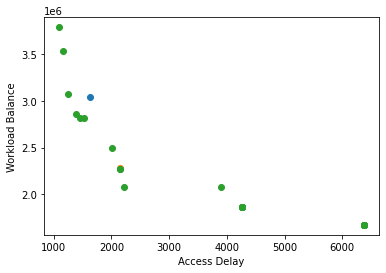

Average Access Delay:3748.4271521743826
Average Workload Balance:2221742.3357904935
Minimum Access Delay:1097.2800970073865
Minimum Workload Balance:1670675.8653898502


In [90]:
frontiers = nonDominatedSort(population)
front1 = {key:value for key,value in population.items() if value.id in frontiers[0]}
top_k = (1634,3047333)
plt.scatter(top_k[0],top_k[1])
random = (2152,2276252)
plt.scatter(random[0],random[1])
ads = []
wbs = []
for key,value in front1.items():
    ads.append(value.accessDelay)
    wbs.append(value.workloadBalance)
plt.xlabel("Access Delay")
plt.ylabel("Workload Balance")
plt.scatter(ads,wbs)
plt.show()
average_ad = sum(ads)/len(ads)
average_wb = sum(wbs)/len(wbs)
print("Average Access Delay:" + str(average_ad))
print("Average Workload Balance:" + str(average_wb))
print("Minimum Access Delay:" + str(min(ads)))
print("Minimum Workload Balance:" + str(min(wbs)))

In [88]:
pop = init_pop(df_200, server_count = 20, pop_size=200)

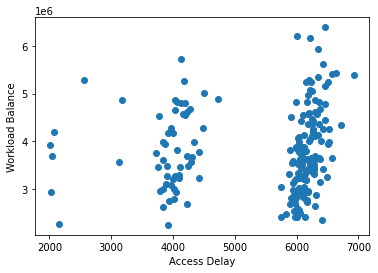

Species: Gen 0, Species:198 Frontier: 0 distance: 0 Access Delay: 2152.339428612145 Workload Balance: 2276252.1388410083 Servers: 22


In [89]:
from scipy import stats
best_score = 1000
best_i = 0
ads = []
wbs = []
for key,value in pop.items():
    ads.append(value.accessDelay)
    wbs.append(value.workloadBalance)
plt.xlabel("Access Delay")
plt.ylabel("Workload Balance")
plt.scatter(ads,wbs)
plt.show()
ads_scores = stats.zscore(ads)
wbs_scores = stats.zscore(wbs)
for i in range(0,len(pop)):
    score = ads_scores[i] + wbs_scores[i]
    if score < best_score:
        best_score = score
        best_i = i
print(pop[best_i])
